In [2]:
"""
Import the library to handle the .pkl files associated to the waveform data.
"""

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

libs_path = os.path.abspath(os.path.join("..", "/jupyter-workspace/private/libs"))
if libs_path not in sys.path:
    sys.path.insert(0, libs_path)

import waveform_structure

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

################## reconstruction data ##################

# version 5.2.   (added getter for the raw waveforms)
# version 5.1.   (added charge calculation)
# version 5.0    (modified selection logic to accept a configfile)
# version 4.1    (fixed get_scalars method)
# version 4.0    (remove plot and plot_multi methods as they were redudant)
# version 3.2    (added getter for track type)
# version 3.1    (added None mode to extract all data without filters)
# version 3.0    (added setters for single cluster and multicluster selection on redpix data and explained plotting method)
# version 2.0    (rewritten get_sc_variables to return only the variables that passed the selection)
# version 1.4    (added a new get_redpix_real method that does not use the muon mask)
# version 1.3.2  (new clusters are selected based on the smallest ymin and tgausssigma)
# version 1.3.1  (modified the methods added in v 1.2 to use the new selected array)
# version 1.3    (returns also the array of actual selected clusters)
# version 1.2    (added 2 methods to plot which tracks have been have passed the filter)
# version 1.1    (modified muon filters)
# version 1.0

class SingleWaveform:
    def __init__(self, run, path, config_file="ConfigFile_dataprocess.txt"):
        self.run = run
        self._read_config(config_file)
        
        self.all_waveforms = self._read_data(run, path)
        self.keys = self.all_waveforms.keys()
        self.n_waveforms = len(self.all_waveforms)

    def _read_config(self, config_file):
        params = {}
        with open(config_file, 'r') as f:
            for line in f:
                if line.strip() and not line.startswith('#'):
                    key, value = line.split('=')
                    params[key.strip()] = float(value.strip())

        self.drift_velocity = params.get('drift_velocity', 6.01e-3) 
        self.min_drop = params.get('min_drop', 2.5)
        self.sigma = params.get('sigma', 4.0)
        self.abs_threshold_mV = params.get('abs_threshold_mV', -14.0)
        self.conversion_factor = params.get('conversion_factor', 2000/4096)
        self.baseline_samples = int(params.get('baseline_samples', 300))
        self.sampling_time = params.get('sampling_time', 4.0)
        self.impedance = params.get('impedance', 50)

    def get_raw_waveforms(self, index):
        data = {}
        for key in self.keys:
            data[key] = self.all_waveforms[key][index]
        return data

    def _read_data(self, run, path):
        f = f"{path}waveforms_run{run}.pkl.gz"
        return pd.read_pickle(f, compression= "gzip")

    def booltrigger(self, index):
        trigger_bool = []
        pmt_keys = ['pmt_1', 'pmt_2']
        
        for key in pmt_keys:
            w = self.all_waveforms[key][index]
            mean = np.mean(w[0:self.baseline_samples])
            w_min = np.min(w - mean)
            trigger_bool.append(w_min <= self.abs_threshold_mV/self.conversion_factor)
    
        return trigger_bool

    def get_n_waveforms(self):
        return self.n_waveforms

    def _merge_clusters(self, starts, ends, tolerance=20):
        if len(starts) < 2:
            return starts, ends

        new_starts = []
        new_ends = []

        curr_start = starts[0]
        curr_end = ends[0]

        for i in range(1, len(starts)):
            if starts[i] - curr_end <= tolerance:
                curr_end = max(curr_end, ends[i])
            else:
                new_starts.append(curr_start)
                new_ends.append(curr_end)
                curr_start = starts[i]
                curr_end = ends[i]

        new_starts.append(curr_start)
        new_ends.append(curr_end)

        return np.array(new_starts), np.array(new_ends)

    def _match_channels(self, s1, e1, s2, e2):
        valid_s1, valid_e1 = [], []
        valid_s2, valid_e2 = [], []

        for i in range(len(s1)):
            for j in range(len(s2)):
                if (s1[i] < e2[j] + 10) and (s2[j] < e1[i] + 10):
                    valid_s1.append(s1[i])
                    valid_e1.append(e1[i])
                    
                    valid_s2.append(s2[j])
                    valid_e2.append(e2[j])
                    break

        return (np.array(valid_s1), np.array(valid_e1), 
                np.array(valid_s2), np.array(valid_e2))

    def cluster_finder(self, wave):
        smooth = -gaussian_filter1d(wave, sigma=self.sigma)
        mean = np.mean(smooth[0:self.baseline_samples])
    
        w = smooth - mean
        N = len(wave)
    
        starts = []
        ends = []
    
        inclu = False
    
        for i in range(N - 5):
            if (w[i] >= self.min_drop) & (inclu == False):
                inclu = True
                starts.append(i)
            if (inclu) & (w[i] < self.min_drop):
                if np.all(w[i:i + 15] < self.min_drop):
                    ends.append(i)
                    inclu = False
    
        if inclu:
            ends.append(N)

        starts_check, ends_check = self._abs_threshold(wave, starts, ends)
        
        return np.array(starts_check), np.array(ends_check)

    def _abs_threshold(self, wave, starts, ends):
        rescaled_wave = wave - np.mean(wave[0:self.baseline_samples])
        N = len(starts)
        new_starts = []
        new_ends = []
        
        for clu in range(N):
            s = starts[clu]
            e = ends[clu]
            if np.min(rescaled_wave[s:e]) <= self.abs_threshold_mV/self.conversion_factor:
                new_starts.append(s)
                new_ends.append(e)

        return new_starts, new_ends

    def geom_eval(self, index):
        pmtup = self.all_waveforms['pmt_up'][index]
        pmtdw = self.all_waveforms['pmt_down'][index]
        pmt1 = self.all_waveforms['pmt_1'][index]
        pmt2 = self.all_waveforms['pmt_2'][index]
        
        s1_raw, e1_raw = self.cluster_finder(pmt1)
        s2_raw, e2_raw = self.cluster_finder(pmt2)
        start_up, end_up = self.cluster_finder(pmtup)
        start_down, end_down = self.cluster_finder(pmtdw)

        s1_m, e1_m = self._merge_clusters(s1_raw, e1_raw, tolerance=25)
        s2_m, e2_m = self._merge_clusters(s2_raw, e2_raw, tolerance=25)

        start_1, end_1, start_2, end_2 = self._match_channels(s1_m, e1_m, s2_m, e2_m)

        data = {
            'pmt_up': np.array([start_up, end_up]),
            'pmt_down': np.array([start_down, end_down]),
            'pmt_1': np.array([start_1, end_1]),
            'pmt_2': np.array([start_2, end_2])
        }

        return data

    def get_z(self, data):
        mean_up = (data['pmt_up'][0] + data['pmt_up'][1]) * 0.5

        if len(mean_up) > 1:
            print('multiple triggers found, using the first')

        if mean_up.size == 0:
            return {
                'pmt_1': np.array([0.0]),
                'pmt_2': np.array([0.0])
            }

        t0 = mean_up[0]

        means_1 = (data['pmt_1'][0] + data['pmt_1'][1]) * 0.5
        means_2 = (data['pmt_2'][0] + data['pmt_2'][1]) * 0.5

        dt_1 = means_1 - t0
        dt_2 = means_2 - t0

        return {
            'pmt_1':dt_1,
            'pmt_2':dt_2
        }

    def get_delta_z(self, data):
        widths_1 = (data['pmt_1'][1] - data['pmt_1'][0])
        widths_2 = (data['pmt_2'][1] - data['pmt_2'][0])

        dt_1 = widths_1
        if widths_1.size == 0:
            dt_1 = np.array([0.0])
            
        dt_2 = widths_2
        if widths_2.size == 0:
            dt_2 = np.array([0.0])

        return {
            'pmt_1':dt_1,
            'pmt_2':dt_2
        }

    def get_data(self, index):
        cluster_data = self.geom_eval(index)
        z = self.get_z(cluster_data)
        delta_z = self.get_delta_z(cluster_data)

        w1_raw = self.all_waveforms['pmt_1'][index]
        w2_raw = self.all_waveforms['pmt_2'][index]
        base1 = np.mean(w1_raw[0:self.baseline_samples])
        base2 = np.mean(w2_raw[0:self.baseline_samples])
        w1 = (w1_raw - base1) * self.conversion_factor
        w2 = (w2_raw - base2) * self.conversion_factor

        n_clu1 = len(z['pmt_1'])
        n_clu2 = len(z['pmt_2'])

        z_1 = []
        z_2 = []
        dz_1 = []
        dz_2 = []

        charge_1 = []
        charge_2 = []
        peak_1 = []
        peak_2 = []

        if n_clu1 > 0:
            starts = cluster_data['pmt_1'][0]
            ends = cluster_data['pmt_1'][1]
            
            for clu in range(n_clu1):
                z_1.append(z['pmt_1'][clu] * self.sampling_time * self.drift_velocity)
                dz_1.append(delta_z['pmt_1'][clu] * self.sampling_time * self.drift_velocity)
                
                s = starts[clu]
                e = ends[clu]
                cluster_wave = w1[s:e]
                
                q = np.sum(np.abs(cluster_wave)) * self.sampling_time / self.impedance
                p = np.max(np.abs(cluster_wave))
                
                charge_1.append(q)
                peak_1.append(p)

        if n_clu2 > 0:
            starts = cluster_data['pmt_2'][0]
            ends = cluster_data['pmt_2'][1]
            
            for clu in range(n_clu2):
                z_2.append(z['pmt_2'][clu] * self.sampling_time * self.drift_velocity)
                dz_2.append(delta_z['pmt_2'][clu] * self.sampling_time * self.drift_velocity)
                
                s = starts[clu]
                e = ends[clu]
                cluster_wave = w2[s:e]
                
                q = np.sum(np.abs(cluster_wave)) * self.sampling_time / self.impedance
                p = np.max(np.abs(cluster_wave))
                
                charge_2.append(q)
                peak_2.append(p)

        return {
            'nclu_pmt_1': n_clu1,
            'nclu_pmt_2': n_clu2,
            'z_coord_pmt_1': z_1,
            'z_coord_pmt_2': z_2,
            'z_delta_pmt_1': dz_1,
            'z_delta_pmt_2': dz_2,
            'charge_pmt_1': charge_1,
            'charge_pmt_2': charge_2,
            'peak_pmt_1': peak_1,
            'peak_pmt_2': peak_2
        }
        
    def get_geometry_data(self):
        z_1 = []
        z_2 = []
        width_1 = []
        width_2 = []
        
        for i in tqdm(range(self.n_waveforms)):
            if np.all(self.booltrigger(i)):
                z_1.append(self.get_data(i)['z_coord_pmt_1'])
                z_2.append(self.get_data(i)['z_coord_pmt_2'])
                width_1.append(self.get_data(i)['z_delta_pmt_1'])
                width_2.append(self.get_data(i)['z_delta_pmt_2'])

        return z_1, z_2, width_1, width_2

    def plot(self, index):
        if not self.booltrigger(index):
            print("No trigger found for this waveform.")
            return

        cluster_data = self.geom_eval(index)
        phys_data = self.get_data(index)
        
        keys = self.keys

        N = len(self.all_waveforms[keys[0]][index])
        t = np.linspace(0, N, N)

        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'

        fig, ax = plt.subplots(2, 4, figsize=(20, 6), gridspec_kw={'height_ratios': [0.5, 2]})

        for i, key in enumerate(keys):
            waveform = self.all_waveforms[key][index] - np.mean(self.all_waveforms[key][index][0:self.baseline_samples])
            mean = np.mean(waveform[0:self.baseline_samples])

            ax[0, i].plot(t, waveform, color='blue', linewidth=.5)
            ax[0, i].set_title(f'{key} (Full-waveform)')

            starts = cluster_data[key][0]
            ends = cluster_data[key][1]

            if len(starts) == 0:
                ax[1, i].text(0.5, 0.5, "No clusters found", transform=ax[1, i].transAxes, ha='center', va='center', fontsize=12)

            else:
                t_start = np.min(starts) - 25
                t_end = np.max(ends) + 25
    
                ax[1, i].plot(t[t_start:t_end], waveform[t_start:t_end] - mean, label='waveform', marker='o', markersize=2.5, linewidth=0.75, color='blue')
    
                for clu in range(len(starts)):
                    label = None
                    if key == 'pmt_1':
                        z = phys_data['z_coord_pmt_1'][clu]
                        dz = phys_data['z_delta_pmt_1'][clu]
                        q = phys_data['charge_pmt_1'][clu]
                        label = f'z={z:.1f}cm, dz={dz:.1f}cm, Q={q:.1f}pC'
                    elif key == 'pmt_2':
                        z = phys_data['z_coord_pmt_2'][clu]
                        dz = phys_data['z_delta_pmt_2'][clu]
                        q = phys_data['charge_pmt_2'][clu]
                        label = f'z={z:.1f}cm, dz={dz:.1f}cm, Q={q:.1f}pC'

                    if label:
                        ax[1, i].axvspan(starts[clu], ends[clu], alpha=0.2, label=label, color='blue')
                    else:
                        ax[1, i].axvspan(starts[clu], ends[clu], alpha=0.2, color='blue')

                ax[1, i].set_xlim(t_start, t_end)
                ax[1, i].set_title(f"{key} (zoom)", fontsize=12)
                ax[1, i].legend(fontsize=10, loc='lower left', fancybox=False, edgecolor='black', framealpha=1)
                ax[1, i].grid(which='both', linestyle='--', linewidth=.5)
                ax[1, i].set_xlabel("Time [ns]", fontsize=11)
                ax[1, i].set_ylabel("Voltage [mV]", fontsize=11)

        plt.tight_layout()
        plt.show()

In [4]:
"""
Here instantiate the actual waveform class
"""

wave_path = '/jupyter-workspace/private/run_data/waveforms/'
run = 13830

#wave = waveform_structure.SingleWaveform(run, wave_path)
wave = SingleWaveform(run, wave_path, config_file='ConfigFile_DataProcess.txt')

[True, True]


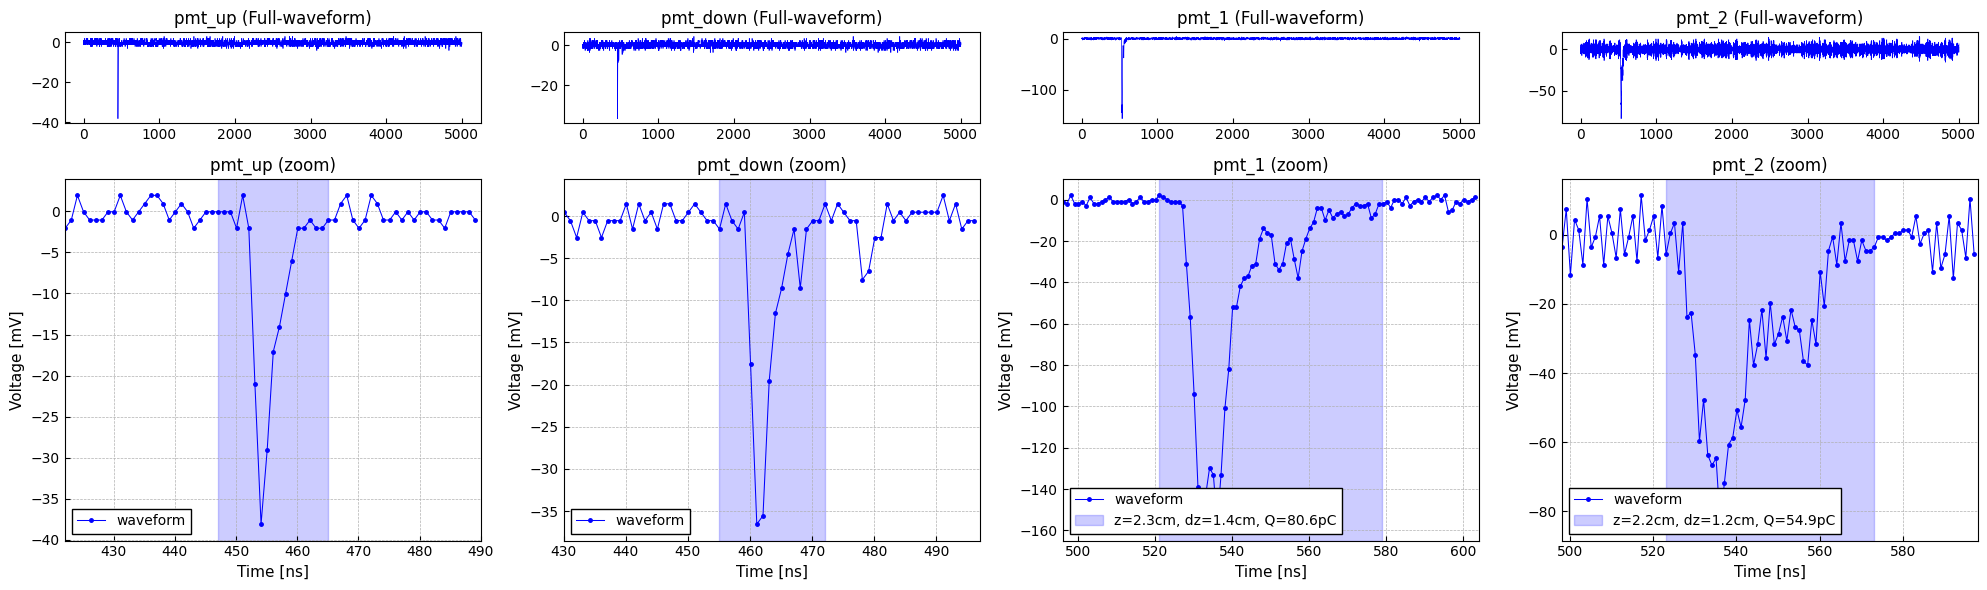

The keys of the data are: dict_keys(['nclu_pmt_1', 'nclu_pmt_2', 'z_coord_pmt_1', 'z_coord_pmt_2', 'z_delta_pmt_1', 'z_delta_pmt_2', 'charge_pmt_1', 'charge_pmt_2', 'peak_pmt_1', 'peak_pmt_2'])


In [5]:
"""
Here test the methods implemented into the class:
"""

conversion_factor = 1000/(4096/2)

# 2V = 4096 ADC -> 1 ADC = 2000 mV/4096

# analysis of the i-th waveform:
i = 2

# first check if there is a potential trigger there:
# this only checks if a signal over threshold is found in the camera side PMTs
print(wave.booltrigger(i))

# plot the waveform to check for consistency:

wave.plot(i)

# finally get the data corresponding to the different events:
# this is a dictionary with 4 keys:

event_data = wave.get_data(i)
print(f'The keys of the data are: {event_data.keys()}')

Raw waveform keys: Index(['pmt_up', 'pmt_down', 'pmt_1', 'pmt_2'], dtype='object')
the length of the pmt_up list is: 500


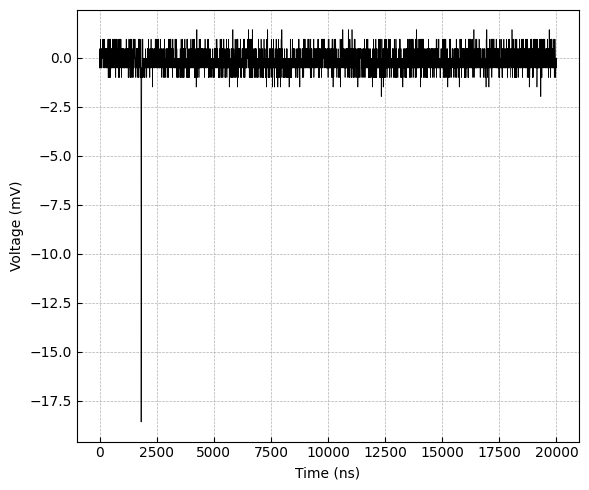

In [6]:
# the raw waveform data can be retrieved in the form of a dictionary

raw_waves = wave._read_data(run, wave_path)

print(f'Raw waveform keys: {raw_waves.keys()}')

# for instance lets take pmt_up

pmt_up_list = raw_waves['pmt_up']
print(f'the length of the pmt_up list is: {len(pmt_up_list)}')

# each entry is a waveform that can be plotted:

temp = np.array(pmt_up_list[i])
baseline_mean = np.mean(temp[0:300])
baseline_std = np.std(temp[0:300])
time = np.linspace(0, len(temp)*4, len(temp))
waveform = (temp - baseline_mean)* conversion_factor

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(time, waveform, linewidth=0.5, color='black')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Voltage (mV)')
ax.grid(linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
from tqdm import tqdm

class PMT_analysis:
    def __init__(self, waveform_analyzer):
        self.wf = waveform_analyzer
        self.n_events = self.wf.get_n_waveforms()

    def get_data(self):
        z1_list = []
        z2_list = []
        q1_list = []
        q2_list = []
        dz1_list = []
        dz2_list = []
        p1_list = []
        p2_list = []

        for i in tqdm(range(self.n_events)):
            if np.all(self.wf.booltrigger(i)):
                data = self.wf.get_data(i)
                
                z1_list.extend(data['z_coord_pmt_1'])
                z2_list.extend(data['z_coord_pmt_2'])
                q1_list.extend(data['charge_pmt_1'])
                q2_list.extend(data['charge_pmt_2'])
                dz1_list.extend(data['z_delta_pmt_1'])
                dz2_list.extend(data['z_delta_pmt_2'])
                p1_list.extend(data['peak_pmt_1'])
                p2_list.extend(data['peak_pmt_2'])

        return {
            'z_pmt1': np.array(z1_list),
            'z_pmt2': np.array(z2_list),
            'charge_pmt1': np.array(q1_list),
            'charge_pmt2': np.array(q2_list),
            'dz_pmt1': np.array(dz1_list),
            'dz_pmt2': np.array(dz2_list),
            'peak_pmt1': np.array(p1_list),
            'peak_pmt2': np.array(p2_list)
        }

In [8]:
pmt_analyser = PMT_analysis(wave)

data = pmt_analyser.get_data()

100%|██████████| 500/500 [00:06<00:00, 78.45it/s] 


dict_keys(['z_pmt1', 'z_pmt2', 'charge_pmt1', 'charge_pmt2', 'dz_pmt1', 'dz_pmt2', 'peak_pmt1', 'peak_pmt2'])


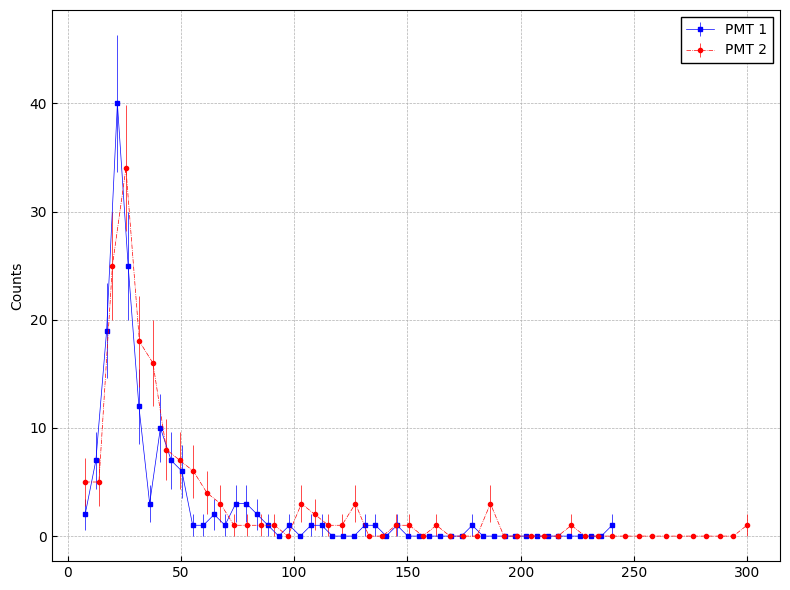

In [10]:
"""
Now you can use this to make histograms or concatenate the list under each key to analyse multiple runs
"""

print(data.keys())
Nbins = 50

y1, bins1 = np.histogram(data['charge_pmt1'], bins=Nbins)
y2, bins2 = np.histogram(data['charge_pmt2'], bins=Nbins)

fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(bins1[:-1], y1, yerr=np.sqrt(y1), color='blue', linestyle='-', marker='s', markersize=3, elinewidth=0.5, linewidth=.5, label='PMT 1')
ax.errorbar(bins2[:-1], y2, yerr=np.sqrt(y2), color='red', linestyle='-.', marker='o', markersize=3, elinewidth=0.5, linewidth=.5, label='PMT 2')
ax.grid(linewidth=0.5, linestyle='--')
ax.set_ylabel('Counts')
ax.legend(loc='upper right', fancybox=False, edgecolor='black', framealpha=1)
plt.tight_layout()
plt.show()